# 🧠 Example 7: Facility Location Model

This example models a **Facility Location Problem**, where we decide **which warehouses to open** and **how to assign customers to those warehouses** to minimize the **total cost**.

---

### Problem Context:

- We have a set of **customers** located at specific coordinates.
- We have a set of potential **warehouse sites** also at specific coordinates.
- Each warehouse has a **fixed setup cost** (cost to open it).
- Shipping cost depends on the **distance** between a warehouse and a customer.
- We want to:
  - **Minimize total cost = Setup cost + Shipping cost**
  - Ensure every customer is fully served (demand is met).
  - Ship only from **opened** warehouses.

---

### How distances are calculated:
- We use **Euclidean distance** between customer and warehouse locations.
- This models real-world distance and transportation cost.

---

### Variables and Decisions:
- **Select[f] = 1** if we open warehouse *f*, 0 otherwise.
- **Assign[c,f]** = fraction of customer *c*’s demand served by warehouse *f* (between 0 and 1).
- Assignments can be fractional, meaning customers can be served from multiple warehouses.

---

### Objective:
Minimize the sum of:
- Warehouse setup costs
- Shipping costs (distance × fraction served × cost per mile)

---

### New Library used:
- **itertools.product:** To generate all pairs of customers and facilities for decision variables.
- **math.sqrt:** To calculate Euclidean distances.

In [11]:
# Facilities Model

from itertools import product
from math import sqrt

import gurobipy as gp
from gurobipy import GRB

# Parameters
customers = [(0,1.5), (2.5,1.2)]
facilities = [(0,0), (0,1), (0,2), (1,0), (1,1), (1,2), (2,0), (2,1), (2,2)]
setup_cost = [3,2,3,1,3,3,4,3,2]
cost_per_mile = 1

# This function determines the Euclidean distance between a facility and customer sites.

def compute_distance(loc1, loc2):
    dx = loc1[0] - loc2[0]
    dy = loc1[1] - loc2[1]
    return sqrt(dx*dx + dy*dy)

# Compute key parameters of MIP model formulation

num_facilities = len(facilities)
num_customers = len(customers)
cartesian_prod = list(product(range(num_customers), range(num_facilities)))

# Compute shipping costs

shipping_cost = {(c,f): cost_per_mile*compute_distance(customers[c], facilities[f]) for c, f in cartesian_prod}

# MIP  model formulation

m = gp.Model('facility_location')

select = m.addVars(num_facilities, vtype=GRB.BINARY, name='Select')
assign = m.addVars(cartesian_prod, ub=1, vtype=GRB.CONTINUOUS, name='Assign')

m.addConstrs((assign[(c,f)] <= select[f] for c,f in cartesian_prod), name='Setup2ship')
m.addConstrs((gp.quicksum(assign[(c,f)] for f in range(num_facilities)) == 1 for c in range(num_customers)), name='Demand')

m.setObjective(select.prod(setup_cost)+assign.prod(shipping_cost), GRB.MINIMIZE)

m.optimize()

# display optimal values of decision variables

for facility in select.keys():
    if (abs(select[facility].x) > 1e-6):
        print(f"\n Build a warehouse at location {facility + 1}.")

# Shipments from facilities to customers.

for customer, facility in assign.keys():
    if (abs(assign[customer, facility].x) > 1e-6):
        print(f"\n Supermarket {customer + 1} receives {round(100*assign[customer, facility].x, 2)} % of its demand  from Warehouse {facility + 1} .")

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i9-14900K, instruction set [SSE2|AVX|AVX2]
Thread count: 24 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 20 rows, 27 columns and 54 nonzeros
Model fingerprint: 0x0939f503
Variable types: 18 continuous, 9 integer (9 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-01, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 20 rows, 27 columns, 54 nonzeros
Variable types: 18 continuous, 9 integer (9 binary)
Found heuristic solution: objective 25.0385165

Root relaxation: objective 4.723713e+00, 15 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       4.7237129    4.72371  0.00

# 🖼️ Visualization

This graph shows:
- Which warehouses are built (red nodes).
- Which customers are connected to which warehouses (edges).
- Unopened warehouses are shown in gray.
- Customer nodes are blue.

Each edge implies a shipment path, with line thickness or color optionally showing shipment proportion or cost (if implemented).

This provides an intuitive picture of the optimal facility placement and customer assignment.


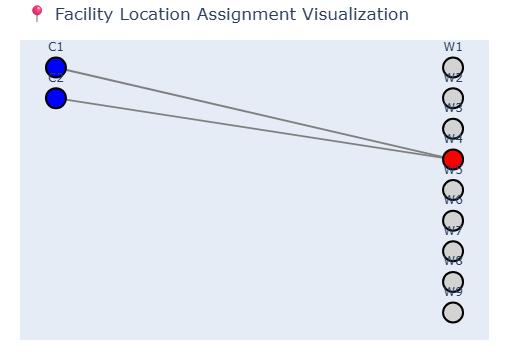

In [12]:
import networkx as nx
import plotly.graph_objects as go

# Node sets and colors
customer_nodes = [f"C{c+1}" for c in range(num_customers)]
facility_nodes = [f"W{f+1}" for f in range(num_facilities)]

# Colors: Blue = customer, Red = open warehouse, Gray = closed warehouse
node_colors = []
for f in range(num_facilities):
    if select[f].x > 0.5:
        node_colors.append('red')   # Open warehouse
    else:
        node_colors.append('lightgray')  # Closed warehouse
node_colors = ['blue']*num_customers + node_colors

# Create graph
G = nx.Graph()

# Add nodes with positions (grid layout)
pos = {}

# Place customers on left (x=0), spaced by y
for idx, c in enumerate(customer_nodes):
    G.add_node(c)
    pos[c] = (0, -idx)

# Place facilities on right (x=2), spaced by y
for idx, f in enumerate(facility_nodes):
    G.add_node(f)
    pos[f] = (2, -idx)

# Add edges for assigned shipments (only if assignment > 0.01)
for (c, f), var in assign.items():
    if var.x > 0.01:
        c_node = f"C{c+1}"
        f_node = f"W{f+1}"
        G.add_edge(c_node, f_node, weight=var.x)

# Create edge traces for Plotly (thickness by assignment fraction)
edge_x = []
edge_y = []
edge_width = []

for edge in G.edges(data=True):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]
    # Scale width for visibility
    edge_width.append(max(1, 10 * edge[2]['weight']))

edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=2, color='gray'),
    hoverinfo='none',
    mode='lines'
)

# Node traces
node_x = [pos[node][0] for node in G.nodes()]
node_y = [pos[node][1] for node in G.nodes()]
node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    hoverinfo='text',
    marker=dict(
        color=node_colors,
        size=20,
        line=dict(width=2, color='black')
    ),
    text=[node for node in G.nodes()],
    textposition="top center"
)

# Create figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title="📍 Facility Location Assignment Visualization",
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=20,r=20,t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                ))

fig.show()
